In [12]:
import os
import numpy as np
from music21 import midi

# Sprawdzamy czy jest do dyspozycji GPU i ewentualnie ustawiamy
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# ładujemy pliki midi z katalogu midi
path = 'midi'
midiz = os.listdir(path)
midis = []
for m in midiz:
    midis.append(os.path.join(path,m))

mf = midi.MidiFile()
mf.open(midis[0]) 
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')


In [16]:

import os
import numpy as np
import py_midicsv as pm
import midi2img
import img2midi
from PIL import Image
    
# zamieniamy pliki midi na obrazy png
for m in midis:
     midi2img.midi2image(m)

img_dir = 'midi_img'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

midi_imgs = os.listdir(path)
for mi in midi_imgs:
    if ".png" in mi:
        basewidth = 106
        img = Image.open(os.path.join(path,mi))
        hsize = 106
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)
        img.save(img_dir+"/"+mi)
        os.remove(os.path.join(path,mi))


C:\Users\pc\AppData\Local\Temp/ipykernel_9428/3584018630.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


In [3]:
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np

# wczytujemy obrazki do listy

path = 'midi_img'
img_list = os.listdir(path)

def get_images(img_list,path):
    pixels = []
    imgs = []
    for imgl in img_list:
        img = Image.open(os.path.join(path,imgl),'r')
        img = img.convert('1')
        pix = np.array(img.getdata())
        pix = pix.astype('float32')
        pix /= 255.0
        pixels.append(pix.reshape(106,106,1))
        imgs.append(img)
    return np.array(pixels),imgs
    
pixels,imgs = get_images(img_list,path)
np.unique(pixels)

In [22]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output
 
# definicje dyskryminatora i generatora

def create_discriminator(in_shape = (106,106,1)):
    model = Sequential()
    model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
def create_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model
 
# tworzenie modelu sieci GAN
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
#funkcja zwracająca wczytane wcześniej obrazy 
def get_real_images(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
# funkcja zwracająca losowe dane dla generatora
def get_latent_data(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

#funkcja zwracająca obrazy wygenerowane przez generator
def get_fake_images(generator, latent_dim, n_samples):
    x_input = get_latent_data(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

#funkcja sprawdzająca skuteczność modelu generatora i wypisująca aktualne wartości accuracy
def print_accuracy(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    X_real, y_real = get_real_images(dataset, n_samples)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = get_fake_images(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    print(' Real data accuracy: %.0f%%, fake data accuracy: %.0f%%' % (acc_real*100, acc_fake*100))

# trening
def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=240, n_batch=16):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        print(f"Epoka {i}")
        for j in range(bat_per_epo):
            X_real, y_real = get_real_images(dataset, half_batch)
            X_fake, y_fake = get_fake_images(generator, latent_dim, half_batch)
            fake = X_fake[0]
            # dla pierwszego batcha każdej epoki wyświetlamy jeden wygenerowany obraz
            if j==0:
              image = X_fake[0].reshape(106, 106)
              plt.imshow(image, cmap='gray')
              plt.show()
       
            # trening modeli
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = discriminator.train_on_batch(X, y)
            X_gan = get_latent_data(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(' %d, %d/%d, d loss=%.3f, g loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 2 == 0: #co jakiś czas wyświetlamy accuracy
            print_accuracy(i, generator, discriminator, dataset, latent_dim)
            clear_output()

# wywołujemy pętlę treningową z naszymi modelami generatora i dyskryminatora
latent_dim = 100
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)
train(generator, discriminator, gan_model, np.array(pixels), latent_dim)

1/1 [==============================] - 0s 24ms/step


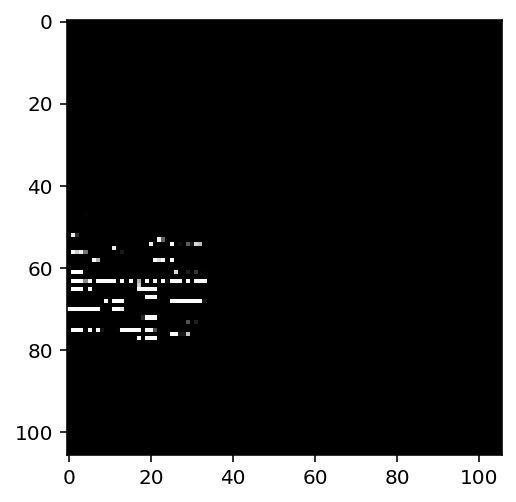

In [30]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


#generujemy obrazek za pomocą modelu generatora
model = generator
latent_points = get_latent_data(latent_dim,1)
X = generator.predict(latent_points)

#zmieniamy kształt wygenerowanych danych do wyświetlenia i zapisania jako png
X = X.reshape(106, 106)
X *=255
plt.imshow(X, cmap='gray')  #wyświetlamy przykładowy wygenerowany obraz z nutami
plt.show()
img = Image.fromarray(X)
img = img.convert("L")
img.save('muzyka.png')

In [33]:
#zamieniamy wygenerowany obrazek na muzykę

image2midi('muzyka.png')

mf = midi.MidiFile()
mf.open("composition.mid") 
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')


106 106
muzyka.png


<ipython-input-2-4a553254369f>:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
